<a href="https://colab.research.google.com/github/priyam314/Deep-Learning/blob/main/Image_Captioning_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np 
import argparse
import pickle 
import os
from PIL import Image
from torchvision import transforms 
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence

## Please DONOT remove these lines. 
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

In [ ]:
# Check availability of GPU and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# this is a simple wrapper for dealing with the vocabulary! 
# this'll be automatically used when you load the provided vocabulary file
class Vocabulary(object):
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        
        # load the resnet152 network provided by torchvision
        resnet = models.resnet152(pretrained=False)
        # remove the last FC layer in the network
        modules = list(resnet.children())[:-1]  
        #define a sequential model with the modules obtained above
        self.resnet = nn.Sequential(*modules)
        # define a linear layer with out_features as embed_size
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        # define a 1d batch norm layer with embed_size as the number of features and a momentum of 0.01 
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        
        # calculate the forward pass in the order of base_model -> linear -> bn
        # reshape features, if necessary
        features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        #### YOUR CODE ENDS HERE ###
        return features

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        super(DecoderRNN, self).__init__()
        self.max_seg_length = max_seq_length
        
        # define an embedding layer with vocab_size as the size of the dictionary
        # and embed_size as the size of each embedding
        self.embed = nn.Embedding(vocab_size, embed_size)
        # define a LSTM layer with embed_size, hidden_size, num_layers, set batch_first to True
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        # define a linear layer with out features as the vocab size
        self.linear = nn.Linear(hidden_size, vocab_size)
        

    def forward(self, features, captions, lengths):
        
        # get embeddings for the captions
        embeddings = self.embed(captions)
        # concatenate the features with embeddings
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

In [ ]:
def main(img_path):
    
    # Image preprocessing
    # define the transforms with normalization values: [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
    transform = transforms.Compose([
        transforms.ToTensor(), # convert to a tensor
        transforms.Normalize((0.485, 0.456, 0.406), # normalise the image
                             (0.229, 0.224, 0.225))])
    
    with open('/content/vocab.pkl', 'rb') as f: # load the vocaulary wrapper file
        vocab = pickle.load(f)

    # build encoder with a embed size of 256
    encoder = EncoderCNN(256).eval()  # eval mode (batchnorm uses moving mean/variance)
    # build decoder with embed_size of 256, hidden_size of 512, vocab_size, 1 layer
    decoder = DecoderRNN(256, 512, len(vocab), 1)
    encoder = encoder.to(device)
    decoder = decoder.to(device)
    
    # load the pre-trained weights for encoder and decoder
    encoder.load_state_dict(torch.load('/content/encoder-5-3000.pkl'))
    decoder.load_state_dict(torch.load('/content/decoder-5-3000.pkl'))
    

    # Prepare an image
    image = Image.open(img_path).convert('RGB')
    image = image.resize([224, 224], Image.LANCZOS)
    image = transform(image).unsqueeze(0)
    image_tensor = image.to(device)
    
    # Generate an caption from the image
    feature = encoder(image_tensor)
    sampled_ids = decoder.sample(feature)
    sampled_ids = sampled_ids[0].cpu().numpy()
    
    # Convert word_ids to words
    sampled_caption = []
    for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        sampled_caption.append(word)
        if word == '<end>':
            break
    sentence = ' '.join(sampled_caption)
    
    # Print out the image and the generated caption
    print (sentence)
    image = Image.open(img_path)
    plt.imshow(np.asarray(image))

<start> a red bus parked on a city street . <end>


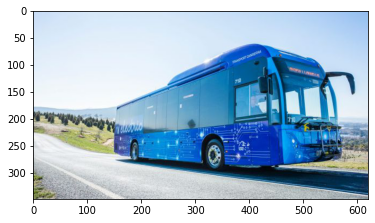

In [ ]:
main('/content/electric_bus.jpg')